In [1]:
import torch
from src.utils import load_data, pad_window_interval
from src.tokenization import tokenize
from src.positional_encoding import positional_encoding
import src.transformer_model
from src.change_points import detect_changes
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from src.dataset import PTBXL
import matplotlib.pyplot as plt

In [2]:
path = './dataset/ecg/WFDB_PTBXL/ptbxl/'
sampling_rate=100
X_train, y_train, X_test, y_test = load_data(path, sampling_rate)

# preprocess data without labels
mask = y_train.apply(lambda x: isinstance(x, list) and len(x) > 0)
y_train = y_train[mask]
X_train = X_train[mask]
y_train = y_train.apply(lambda x: x[0]).astype('category')
y_train = torch.tensor(y_train.cat.codes.values, dtype=torch.long)

print(torch.unique(y_train))

tensor([0, 1, 2, 3, 4])


In [7]:
def normalize(data):
    # Compute mean and std per channel
    mean_vals = data.mean(axis=2, keepdims=True)
    std_vals = data.std(axis=2, keepdims=True)

    return (data - mean_vals) / (std_vals + 1e-8)


In [ ]:


import importlib
importlib.reload(src.transformer_model)
from src.transformer_model import TimeSeriesTransformer

window_size = None
overlap=10

model_inputs = []

# (19000, 1000, 12)
for time_series in X_train:
    # min max normalization
    time_series = normalize(time_series)
    change_points = detect_changes(time_series)

    # Tokenize the data
    tokens = tokenize(torch.from_numpy(time_series), window_size, overlap, change_points)

    # Generate positional encodings
    pos_encoding = positional_encoding(tokens.shape[0], tokens.shape[1]).unsqueeze(-1) # (4, 442, 1)
    
    model_input = torch.cat((tokens, pos_encoding), dim=-1)

    model_inputs.append(model_input)


padded_window_seq = pad_window_interval(model_inputs)
padded_input_seq = pad_sequence(padded_window_seq, batch_first=True)
padded_input_seq = padded_input_seq.float()


dataset = PTBXL(padded_input_seq, y_train)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
input_dim = 2756               # Number of features (12 channels + positional encoding) * window size
d_model = 64                  # Dimension of embeddings (output from transformer)
num_heads = 8                 # Number of attention heads
num_layers = 6                # Number of encoder layers
dim_feedforward = 256         # Feedforward layer dimension
dropout = 0.1                 # Dropout rate
num_classes = 5
model = TimeSeriesTransformer(
    input_dim=input_dim,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    dim_feedforward=dim_feedforward,
    dropout=dropout,
    num_classes=num_classes,
)
learning_rate = 0.001
num_epochs = 3

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



/opt/homebrew/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Wrap the dataloader with tqdm
    for inputs, labels in tqdm(dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch'):
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        running_loss += loss.item()

    average_loss = running_loss / len(dataloader)
    print(f'Average Loss: {average_loss:.4f}')

print("Training complete!")

Epoch 1/3:   0%|          | 0/1 [00:00<?, ?batch/s]

input torch.Size([5, 63, 212, 13])
torch.float32
torch.Size([5, 63, 64])
torch.Size([5, 64])
output torch.Size([5, 5])


Epoch 1/3: 100%|██████████| 1/1 [00:00<00:00, 14.52batch/s]


Average Loss: 1.6058


Epoch 2/3: 100%|██████████| 1/1 [00:00<00:00, 65.62batch/s]


input torch.Size([5, 63, 212, 13])
torch.float32
torch.Size([5, 63, 64])
torch.Size([5, 64])
output torch.Size([5, 5])
Average Loss: 0.7856


Epoch 3/3: 100%|██████████| 1/1 [00:00<00:00, 62.99batch/s]

input torch.Size([5, 63, 212, 13])
torch.float32
torch.Size([5, 63, 64])
torch.Size([5, 64])
output torch.Size([5, 5])
Average Loss: 0.2804
Training complete!


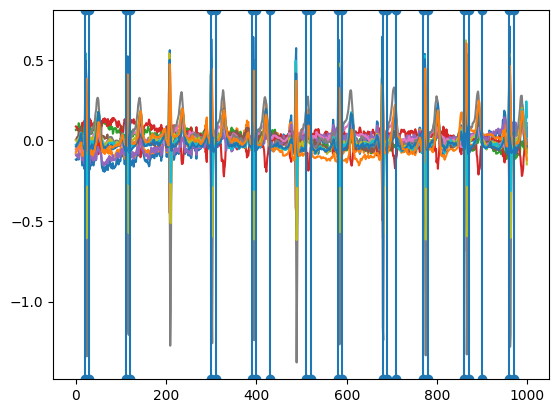

In [10]:
# Load and prepare data

window_size = None
path = './dataset/ecg/WFDB_PTBXL/ptbxl/'
sampling_rate=100
X_train, y_train, X_test, y_test = load_data(path, sampling_rate)

# TODO: preprocessing

model_inputs = []

# (19000, 1000, 12)
for time_series in X_train[0:5]:
    
    change_points = detect_changes(time_series)

    plt.plot(time_series)

    for cp in change_points:
        plt.axvline(x=cp, marker='o', label="Time Series")

    break

    # Tokenize the data
    tokens = tokenize(torch.from_numpy(time_series), window_size, overlap, change_points)

    # Generate positional encodings
    pos_encoding = positional_encoding(tokens.shape[0], tokens.shape[1]).unsqueeze(-1) # (4, 442, 1)
    
    model_input = torch.cat((tokens, pos_encoding), dim=-1)

    model_inputs.append(model_input)


    